### Prerequisites:

 - We will use [pandas](https://pandas.pydata.org/docs/) for data processing,
 - and Meta's open-source LLM [Llama 3.1](https://huggingface.co/meta-llama/Llama-3.1-8B-Instruct) for prompting and few-shot learning.
- All experiments will be performed on the [Food Recall Incidents Dataset](https://doi.org/10.5281/zenodo.10891602).

In [47]:
%%capture
# install dependecies:
!pip install numpy torch pandas scikit-learn transformers tqdm
# download dataset:
!wget https://zenodo.org/records/10891602/files/food_recall_incidents.csv

### Data processing

In [48]:
import pandas as pd

data = pd.read_csv('food_recall_incidents.csv', index_col=0)
data.sample()

,year,month,day,title,product,product-category,product-title,hazard,hazard-category,hazard-title,language,country
4907,2021,3,26,GUT&GÜNSTIG Tiefkühl-Beerenmischung mit Sauerk...,frozen berries mix,fruits and vegetables,NaN,metal fragment,foreign bodies,NaN,de,de


We use the `hazard-category` from the `title` of the food recall as the target label to predict, but others c/should be tried as well (e.g., `product-category`):

In [49]:
# select input and label from data:
X = data['title'].to_numpy()
y = data['hazard-category'].to_numpy()

In [58]:
from sklearn.model_selection import train_test_split

# create test set:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=42, shuffle=True, stratify=y)
print('Size of test set : ', X_test.shape[0])
print('Size of train set: ', X_train.shape[0])
classes = set(y_train)
print('Classes: ', len(classes))

Size of test set :  599
Size of train set:  5385
Classes:  10


### Sparse Frquency-based Embeddings for Similarity

We import TfidfVectorizer from `sklearn.feature_extraction.text` and use it to create and fit a TF-IDF input embedding on the `X_train` data. Since `TfidfVectorizer.transform(...)` returns a sparse matrix.

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer
# create and train input embedding:
tfidf = TfidfVectorizer().fit(X_train)

In [53]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def fetch_most_similar_train_vectors(test_vector, train_vectors, k=1):
    """
    For a given test TF-IDF vector, find the k most similar train TF-IDF vectors
    using cosine similarity.

    Args:
        test_vector: The TF-IDF vector for a single test instance.
        train_vectors: A sparse matrix of TF-IDF vectors for the training set.
        k: The number of most similar vectors to return.

    Returns:
        A list of indices of the k most similar train vectors.
    """
    # Calculate cosine similarity between the test vector and all train vectors
    # Reshape test_vector to be a 2D array for cosine_similarity
    similarities = cosine_similarity(test_vector.reshape(1, -1), train_vectors)

    # Get the indices of the top k most similar vectors
    # Use argsort to get indices in ascending order, then slice the last k
    # Flatten similarities to a 1D array for argsort
    most_similar_indices = np.argsort(similarities.flatten())[-k:]

    return most_similar_indices[::-1] # Return indices in descending order of similarity

In [54]:
X_train_tfidf = tfidf.transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

t = X_test_tfidf[0] # test text
n = 3 # shots
similar_indices = fetch_most_similar_train_vectors(t, X_train_tfidf, k=n)
print(f"Most similar train indices for the first test sample\n'{X_test[0]}' (n={n}):{similar_indices}\n")
for i, idx in enumerate(similar_indices): print(i+1, X_train[idx])

Most similar train indices for the first test sample
'Recall of a Batch of The Proper Dairy Company Irish Farm Halloumi due to the Presence of Listeria monocytogenes' (n=3):[4554 2975 1808]

1 Recall of a Batch of Burren Smokehouse Smoked Irish Organic Salmon Due to the Presence of Listeria monocytogenes
2 Recall of a Batch of Bosna Smoked Roast Beef Due to the Presence of Listeria monocytogenes
3 Recall of a Batch of Marcel Urechi Snacks due to the Presence of Listeria monocytogenes


### Instantiate Llama

In order to be able to use huggingface's Llama 3.1 models, we first need to log in to huggingface (you can request access to the model [here](https://huggingface.co/meta-llama/Llama-3.1-8B-Instruct)).

In [15]:
import getpass
from huggingface_hub import login
login(getpass.getpass('Enter your huggingface API-key:'))

Enter your huggingface API-key:··········


In this tutorial we will use the standard huggingface textgeneration pipeline (compressed to 16 bit floating point weights) for the instruction tuned 8B parameter version of Llama 3.1.

In [54]:
%%capture
import transformers
import torch

# create llm pipeline:
llm = transformers.pipeline(
    "text-generation",
    model="meta-llama/Meta-Llama-3.1-8B-Instruct",
    model_kwargs={"torch_dtype": torch.bfloat16},
    device_map="auto"
)

# Get special tokens for later:
bos_token_id = llm.tokenizer.convert_tokens_to_ids('<|begin_of_text|>')
eos_token_id = llm.tokenizer.convert_tokens_to_ids('<|eot_id|>')
pad_token_id = llm.tokenizer.convert_tokens_to_ids('<|eot_id|>')

### Few-shot learning

Generate a prompt for classification using a given text and $n$ labeled examples.


In [68]:
def get_prompt(text, shots):
    prompt = 'We classify food hazard labels from texts, as in the following examples:\n'
    for x,y in shots: prompt += f'\n"{x}": {y}'
    return {"role": "user", "content": f'{prompt}\n\nThe valid labels are: {", ".join(classes)}.\nPredict the correct label for the following text, but generate only the label and no other text.\n\n"{text}": '}

shots_idxs = fetch_most_similar_train_vectors(X_test_tfidf[0], X_train_tfidf, k=n)
shots = [(X_train[idx], y_train[idx]) for idx in shots_idxs]
prompt = get_prompt(X_test[0], shots)["content"]
print(prompt)

We classify food hazard labels from texts, as in the following examples:

"Recall of a Batch of Burren Smokehouse Smoked Irish Organic Salmon Due to the Presence of Listeria monocytogenes": biological
"Recall of a Batch of Bosna Smoked Roast Beef Due to the Presence of Listeria monocytogenes": biological
"Recall of a Batch of Marcel Urechi Snacks due to the Presence of Listeria monocytogenes": biological

The valid labels are: allergens, other hazard, organoleptic aspects, chemical, migration, biological, packaging defect, food additives and flavourings, foreign bodies, fraud.
Predict the correct label for the following text, but generate only the label and no other text.

"Recall of a Batch of The Proper Dairy Company Irish Farm Halloumi due to the Presence of Listeria monocytogenes": 


In [70]:
from tqdm.notebook import tqdm

def few_shot_learning_batch(test, test_tfidf, train, train_tfidf, y_train, n=3):
  outputs = []
  for i,t in tqdm(enumerate(X_test_tfidf)):
      shots_idxs = fetch_most_similar_train_vectors(t, train_tfidf, k=n)
      shots = [(train[idx], y_train[idx]) for idx in shots_idxs]
      prompt = get_prompt(test[i], shots)["content"]
      response = llm([prompt],
                    bos_token_id=bos_token_id,
                    eos_token_id=eos_token_id,
                    pad_token_id=pad_token_id,
                    max_new_tokens=1,
                    do_sample=False,
                    temperature=None,
                    top_p=None)
      label = response[0][0]["generated_text"].split(':')[-1].strip()
      outputs.append(label)
  return outputs

predictions = few_shot_learning_batch(X_test, X_test_tfidf, X_train, X_train_tfidf, y_train, n=3)

In [71]:
predictions[:10]

['biological',
 'allerg',
 'biological',
 'biological',
 'allerg',
 'biological',
 'allerg',
 'organ',
 'biological',
 'chemical']

Classification Report:
               precision    recall  f1-score   support

        alle       0.00      0.00      0.00       196
        biol       0.68      0.88      0.77       202
        chem       0.76      0.58      0.66        50
        food       0.00      0.00      0.00         3
        fore       0.00      0.00      0.00        77
        frau       0.62      0.44      0.51        41
        migr       0.00      0.00      0.00         1
        orga       0.00      0.00      0.00         6
        othe       0.02      0.40      0.04        15
        pack       0.00      0.00      0.00         8

    accuracy                           0.39       599
   macro avg       0.21      0.23      0.20       599
weighted avg       0.34      0.39      0.35       599

Accuracy: 0.38564273789649417


Text(0.5, 1.0, 'Confusion Matrix')

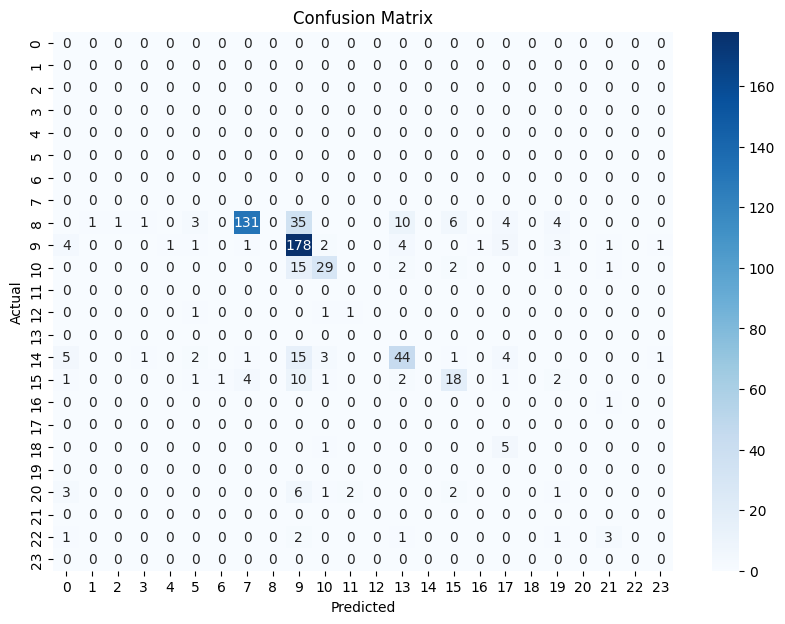

In [76]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def clean(labels, classes=classes, lim=4):
  labels = [lbl if lbl in classes else 'other' for lbl in labels]
  labels_short = [lbl[:lim] for lbl in labels]
  return labels_short

print("Classification Report:\n", classification_report(clean(y_test), clean(predictions), zero_division=0))
print("Accuracy:", accuracy_score(clean(y_test), clean(predictions)))

# Plot confusion matrix
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix')